# Document Intelligence Processor Walkthrough
This notebook walks through the Document Intelligence processor component that is included in this repository. It is useful for converting the raw API response from Document Intelligence into something more useful, and which can be easily converted into the format required for sending to an LLM endpoint.

Some features include:
* Automatic extraction of rich content in a PDF, including tables, figures and more.
* Output of text content in a PDF, images for each page and figure within the PDF, and pandas dataframes for tables within the PDF.
* Automatic correction of image rotation when extracting page and figure images (if not corrected, this can completely destroy LLM extraction accuracy)
* Custom definition of the content outputs, allowing for completely dynamic formatting of all content in a file.
* Chunking of content into smaller parts (e.g. into chunks of X pages) which can then be processed as part of a Map Reduce pattern.

In [1]:
import json
import os
from dataclasses import dataclass

from IPython.display import Markdown as md
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import (
    AnalyzeResult,
    AnalyzeDocumentRequest,
    DocumentAnalysisFeature,
)

# ignore cryptography version warnings
import warnings
warnings.filterwarnings(action='ignore', module='.*cryptography.*')

# Append src module to system path to import from src module
import sys
sys.path.append(os.path.abspath("../function_app"))

from src.components.doc_intelligence import (
    DefaultDocumentPageProcessor, 
    DefaultDocumentTableProcessor, DefaultDocumentFigureProcessor,
    DefaultDocumentParagraphProcessor, DefaultDocumentLineProcessor,
    DefaultDocumentWordProcessor, DefaultSelectionMarkFormatter,
    DefaultDocumentSectionProcessor, DocumentIntelligenceProcessor, 
    PageDocumentListSplitter, convert_processed_di_docs_to_openai_message,
    convert_processed_di_docs_to_markdown,
)
from src.helpers.data_loading import load_pymupdf_pdf, extract_pdf_page_images

In [2]:
# Load environment variables
load_dotenv(override=True)

# Auto-reload modules
%load_ext autoreload
%autoreload 2

# Display all outputs of a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Load environment variables from Function App local settings file
with open("../function_app/local.settings.json", "rb") as f:
    local_settings = json.load(f)
    os.environ.update(local_settings["Values"])

DOC_INTEL_ENDPOINT = os.getenv("DOC_INTEL_ENDPOINT")
DOC_INTEL_API_KEY = os.getenv("DOC_INTEL_API_KEY")

# Construct the Document Intelligence client
di_client = DocumentIntelligenceClient(
    endpoint=DOC_INTEL_ENDPOINT, 
    credential=AzureKeyCredential(DOC_INTEL_API_KEY),
    api_version="2024-07-31-preview",
)

## Note: This notebook currently only supports the Document Intelligence API version 2024-07-31-preview (v4.0)

The latest version (v4.0) of Document Intelligence is only available in a handful of regions. The older v3.1 API will soon be supported to ensure that the code in this notebook will work with Document Intelligence resources across all Azure regions.

In [4]:
# Define helper objects
@dataclass
class SamplePdfFileInfo:
    name: str
    description: str
    url_source: str

def get_analyze_document_result(
    sample_pdf_file_info: SamplePdfFileInfo,
    di_client: DocumentIntelligenceClient,
    model_id: str = "prebuilt-layout",
    **kwargs
) -> AnalyzeResult:
    """
    Gets the AnalyzeResult for a sample PDF file using the Document Intelligence
    client.
    """
    poller = di_client.begin_analyze_document(
        model_id=model_id,
        analyze_request=AnalyzeDocumentRequest(url_source=sample_pdf_file_info.url_source),
        **kwargs
    )
    new_result = poller.result()
    return new_result

# Setup a list of PDFs for testing
We will use a set of PDFs for showcasing how the processor works. These examples include different elements such as tables, inline figures, document structures/heirarchies, and lengths/pages. You can add your own files here for testing.

In [5]:
# Get raw file links
doc_intelligence_test_files = {
    "ikea": SamplePdfFileInfo(
        name="IKEA Installation Manual",
        description=(
            "An instruction manual for installing an Ikea kitchen. "
            "This document contains 12 pages, consisting of a series of diagrams and written instructions. "
            "This shows how we can extract individual figures and text from the document."
        ),
        url_source="https://www.ikea.com/au/en/files/pdf/c7/ef/c7ef4878/kitchen-installation-guide_fy22.pdf",
    ),
    "rotated_image_pdf": SamplePdfFileInfo(
        name="Rotated Image PDF",
        description=(
            "A single-page PDF containing an embedded image. "
            "This document Shows how we can automatically extracted images from a PDF, "
            "correcting the rotation of the page and figures images automatically."
        ),
        url_source="https://github.com/pymupdf/PyMuPDF/blob/main/tests/resources/test_delete_image.pdf?raw=true",
    ),
    "editorial_page": SamplePdfFileInfo(
        name="Editorial Page (Mixed content)",
        description=(
            "A single-page editorial article with a mix of text and figures on the page. "
            "Another example  extracting both text and figures from the page."
        ),
        url_source="https://github.com/pymupdf/PyMuPDF/blob/main/tests/resources/001003ED.pdf?raw=true",
    ),
    "multicolumn_pdf": SamplePdfFileInfo(
        name="Multicolumn PDF with table",
        description="A 3-page test PDF containing multi-column text and a table to be extracted.",
        url_source="https://github.com/py-pdf/sample-files/blob/main/026-latex-multicolumn/multicolumn.pdf?raw=true",
    ),
    "rotated_proof_of_delivery_pdf": SamplePdfFileInfo(
        name="Rotated Delivery Receipt",
        description="A 3-page test PDF containing multi-column text and a table to be extracted.",
        url_source="https://github.com/Azure/multimodal-ai-llm-processing-accelerator/blob/main/demo_app/demo_files/Rotated%20Proof%20of%20Delivery%20Receipt.jpg?raw=true",
    ),
}

# Print file links
print("Sample PDF files to analyze:")
for name, sample_pdf_file_info in doc_intelligence_test_files.items():
    print(f"- '{name}': {sample_pdf_file_info.description}")

Sample PDF files to analyze:
- 'ikea': An instruction manual for installing an Ikea kitchen. This document contains 12 pages, consisting of a series of diagrams and written instructions. This shows how we can extract individual figures and text from the document.
- 'rotated_image_pdf': A single-page PDF containing an embedded image. This document Shows how we can automatically extracted images from a PDF, correcting the rotation of the page and figures images automatically.
- 'editorial_page': A single-page editorial article with a mix of text and figures on the page. Another example  extracting both text and figures from the page.
- 'multicolumn_pdf': A 3-page test PDF containing multi-column text and a table to be extracted.
- 'rotated_proof_of_delivery_pdf': A 3-page test PDF containing multi-column text and a table to be extracted.


## Define Document Intelligence configuration
First up, we will set the configuration for the Document Intelligence API request.

In [6]:
### Document Intelligence config

# Select the model type. 
# More info here: https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/model-overview
di_model_id = "prebuilt-layout" # E.g. "prebuilt-read" or "prebuilt-document"

# Select additional Document Intelligence features to extract. 
# More info here: https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept/add-on-capabilities
di_features = [
    # DocumentAnalysisFeature.BARCODES,
    # DocumentAnalysisFeature.FORMULAS,
    # DocumentAnalysisFeature.KEY_VALUE_PAIRS,
    # DocumentAnalysisFeature.STYLE_FONT,
    # DocumentAnalysisFeature.QUERY_FIELDS,
]
print("Possible Document Intelligence Features:", [e.value for e in DocumentAnalysisFeature])
print("Selected Document Intelligence Features:", di_features)

Possible Document Intelligence Features: ['ocrHighResolution', 'languages', 'barcodes', 'formulas', 'keyValuePairs', 'styleFont', 'queryFields']
Selected Document Intelligence Features: []


## Define Document Intelligence Processor configuration
Now we will define the configuration for the processing of the result for Doc Intelligence.

Document Intelligence returns many different element objects which correspond to different types of content in the document. Some examples are pages, sections, paragraphs, lines, words, figures, tables and more. Each of these elements have a corresponding processor which is designed to handle that type of element. These processors may simply format the output (e.g. for paragraphs and lines), but others may perform data processing to load and convert the raw API response into something more usable.

Here are some key things to look at:

##### 1. Processed output dataclass type (Haystack `Document`s)
Because the resulting information comes in different types (e.g. text, images, or dataframes), the processors use Haystack's Document dataclass as the standardised data structure for storing the content. These can then be post-processed into other formats such as OpenAI message dictionaries.

##### 2. Formatting text content
When outputting text, the format of that text can be customized using the `*_text_formats` parameters of each element processor. The format can be defined such that different elements are returned in a specific format (such as italicing text or adding prefixes or suffixes). The format can feature placeholders for different parts of the content, with the list of possible placeholders shown in the constructor docstring for each processor class. 
* If the processor processes an element that does not contain any information for the placeholder, that format will be skipped. 
* For example, if the text formats for a figure processor was ["*Figure Caption:* {caption}", "*Figure Footnotes:* {footnotes}", "*Figure Content:*\n{content}"] but the figure did not have any captions or footnotes, only the final text_format string would be returned in the result. 
* Final result: "*Figure Content:\n<text_extracted_from_inside_the_image>"

##### 3. Outputting and rotating images
The Page and Figure processors can automatically output page and figure images into the output, maintaining the correct order of the content. These processors can also automatically adjust the rotation of the image using the `angle` of the page as detected by Document Intelligence. This can ensure that all output images are rotated correctly prior to storing and using those images (this makes a big difference in how accurately LLM's can analyze those images).

##### 4. Splitting output `Document`s into chunks
When processing large documents, it can be useful to split the original document into separate chunks prior to processing. While the processors are not meant to completely replace other chunking tools (e.g. those in `Langchain` and other libraries), most chunkers are only designed to work with text content and will break if they are given multimodal data. To help avoid this, a `Splitter` can be used to split processed results. The default option is the `PageDocumentListSplitter`, which can split the list of full outputs into chunks based on the page number of the original content. This is useful in cases where you want to take a large Document (e.g. 50+ pages) and process those the document in chunks, then combine the chunk results into a final document-level result. This is a common pattern in document processing (known as the Map Reduce pattern).

##### 5. Merging output `Document`s 
By default, each individual element within a document will result in 1 or more outputs. This means that a single page of paragraphs, lines or words would result in many different output `Document`s. Converting these to LLM messages would then result in hundreds of messages for each document. To prevent this, we can merge adjacent text elements together to reduce the number of text objects prior to converting them into LLM messages. This is accomplished with the 
* Example result:
* Original documents: [text, text, image, text, text, text, table (markdown), text, image]
* Merged documents: [text, image, text, image]

In [7]:
### Document Intelligence Processor config

# Define processors for individual components
selection_mark_formatter = DefaultSelectionMarkFormatter(
    selected_replacement="[X]", 
    unselected_replacement="[ ]"
)
section_processor = DefaultDocumentSectionProcessor(
    text_format=None,
)
page_processor = DefaultDocumentPageProcessor(
    page_start_text_formats=["\n*Page {page_number} content:*"],
    page_end_text_formats=None,
    page_img_order="after",
    page_img_text_intro="*Page {page_number} Image:*",
    img_export_dpi=100,
    adjust_rotation = True,
    rotated_fill_color = (255, 255, 255),
)
table_processor = DefaultDocumentTableProcessor(
    before_table_text_formats=["**Table {table_number} Info**\n", "*Table Caption:* {caption}", "*Table Footnotes:* {footnotes}", "*Table Content:*"],
    after_table_text_formats=None,
)
figure_processor = DefaultDocumentFigureProcessor(
    before_figure_text_formats=["**Figure {figure_number} Info**\n", "*Figure Caption:* {caption}", "*Figure Footnotes:* {footnotes}", "*Figure Content:*\n{content}"],
    output_figure_img=True,
    figure_img_text_format="*Figure Image:*",
    after_figure_text_formats=None,
)
paragraph_processor = DefaultDocumentParagraphProcessor(
    general_text_format = "{content}",
    page_header_format = None,
    page_footer_format = None,
    title_format = "\n{heading_hashes} {content}",
    section_heading_format = "\n{heading_hashes} {content}",
    footnote_format = "*Footnote:* {content}",
    formula_format = "*Formula:* {content}",
    page_number_format = None,
)
line_processor = DefaultDocumentLineProcessor()
word_processor = DefaultDocumentWordProcessor()

# Now construct the DocumentIntelligenceProcessor class which uses each of these sub-processors
doc_intel_result_processor = DocumentIntelligenceProcessor(
    page_processor = page_processor,
    section_processor = section_processor,
    table_processor = table_processor,
    figure_processor = figure_processor,
    paragraph_processor = paragraph_processor,
    line_processor = line_processor,
    word_processor = word_processor,
    selection_mark_formatter = selection_mark_formatter
)

# Now construct the a splitter class which can separate the outputs into different chunks
chunk_splitter = PageDocumentListSplitter(pages_per_chunk=3)

# Process Documents
We will now process our documents, inspecting the result and converting it into various formats.

==================== PROCESSING TEST PDF: 'rotated_proof_of_delivery_pdf' =========================

Output info:

- Number of pages in the file: 1
- Number of content Documents: 33
- Number of content Documents after merging adjacent text Documents: 6
- Number of content chunks after splitting the Documents by page: 1

Printing the content in markdown format
*** Chunk 1 Content ***


*Page 1 content:*


**Figure 1 Info**

*Figure Content:*
MORRISON SUPPLY COMPANY a MORSCO company


*Figure Image:*

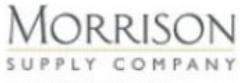

BRANCH: 1001 ABILENE 242 SOUTH TREADAWAY BLVD ABILENE TX 79602-1747 Phone: 325-677-8174
BILL TO:
ANSON PARK I
2934 OLD ANSON RD
ABILENE TX 79603-1838

# INVOICE


**Table 1 Info**

*Table Content:*
| INVOICE DATE   | INVOICE NUMBER   |
|----------------|------------------|
| 02/28/2017     | S101589595.001   |



**Table 2 Info**

*Table Content:*
| PLEASE REMIT TO:                             | PAGE NO.    |
|----------------------------------------------|-------------|
| MORRISON SUPPLY COMPANY PO BOX 309           | Page 1 of 1 |
| FORT WORTH TX 76101-0309 Phone: 817-484-4676 |             |

SHIP TO:
ANSON PARK I SHOP
2934 OLD ANSON RD
ABILENE TX 79603-1838


**Table 3 Info**

*Table Content:*
|   CUSTOMER NUMBER | CUSTOMER PO NUMBER   | JOB NAME / RELEASE NUMBER   | SALESPERSON   |
|-------------------|----------------------|-----------------------------|---------------|
|             64481 | Serv Chrg            |                             |               |



**Table 4 Info**

*Table Content:*
| WRITER   | SHIP VIA   | TERMS         | SHIP DATE   | ORDER DATE   |
|----------|------------|---------------|-------------|--------------|
|          | ACCOUNTING | NET 15TH PROX | 02/28/2017  | 02/28/2017   |



**Table 5 Info**

*Table Content:*
| ORDER QTY   | SHIP QTY   | PRODUCT ID   | DESCRIPTION                                 |   UNIT PRICE |   EXT PRICE |
|-------------|------------|--------------|---------------------------------------------|--------------|-------------|
| 1ea         | 1ea        |              | SERVICE CHARGE This Finance Charge is being |         6.81 |        6.81 |



**Figure 2 Info**

*Figure Content:*
SAVE TIME
S
$ SAVE MONEY


*Figure Image:*

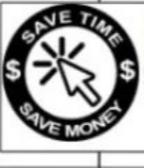

SAVE TIME AND MONEY BY PAYING ONLINE Our goal is to make it easy for you to manage the invoices you receive from us. For the ultimate in convenience try our online bill payment portal. You will be notified by email when new invoices are posted. You can view, print, download and pay your invoices online. Save time and money by going paperless. Visit http://www.Morsco.com to enroll.
For TERMS and CONDITIONS, See "TERMS PAGE."
Invoice is due by 03/15/2017. All claims for shortages or errors must be made at once, returns require written authorization and are subject to handling charges. Special orders are non-returnable.


**Table 6 Info**

*Table Content:*
| <!-- -->    |   <!-- --> |
|-------------|------------|
| Subtotal    |       6.81 |
| S&H Charges |       0    |
| Tax         |       0    |
| Payments    |       0    |
| Amount Due  |       6.81 |



**Table 7 Info**

*Table Content:*
| TO VIEW ONLINE   | http://morsco.billtrust.com   |
|------------------|-------------------------------|
| ENROLLMENT TOKEN | MKV DMB VVR                   |
| ACCOUNT NUMBER   | 10470                         |



*Page 1 Image:*

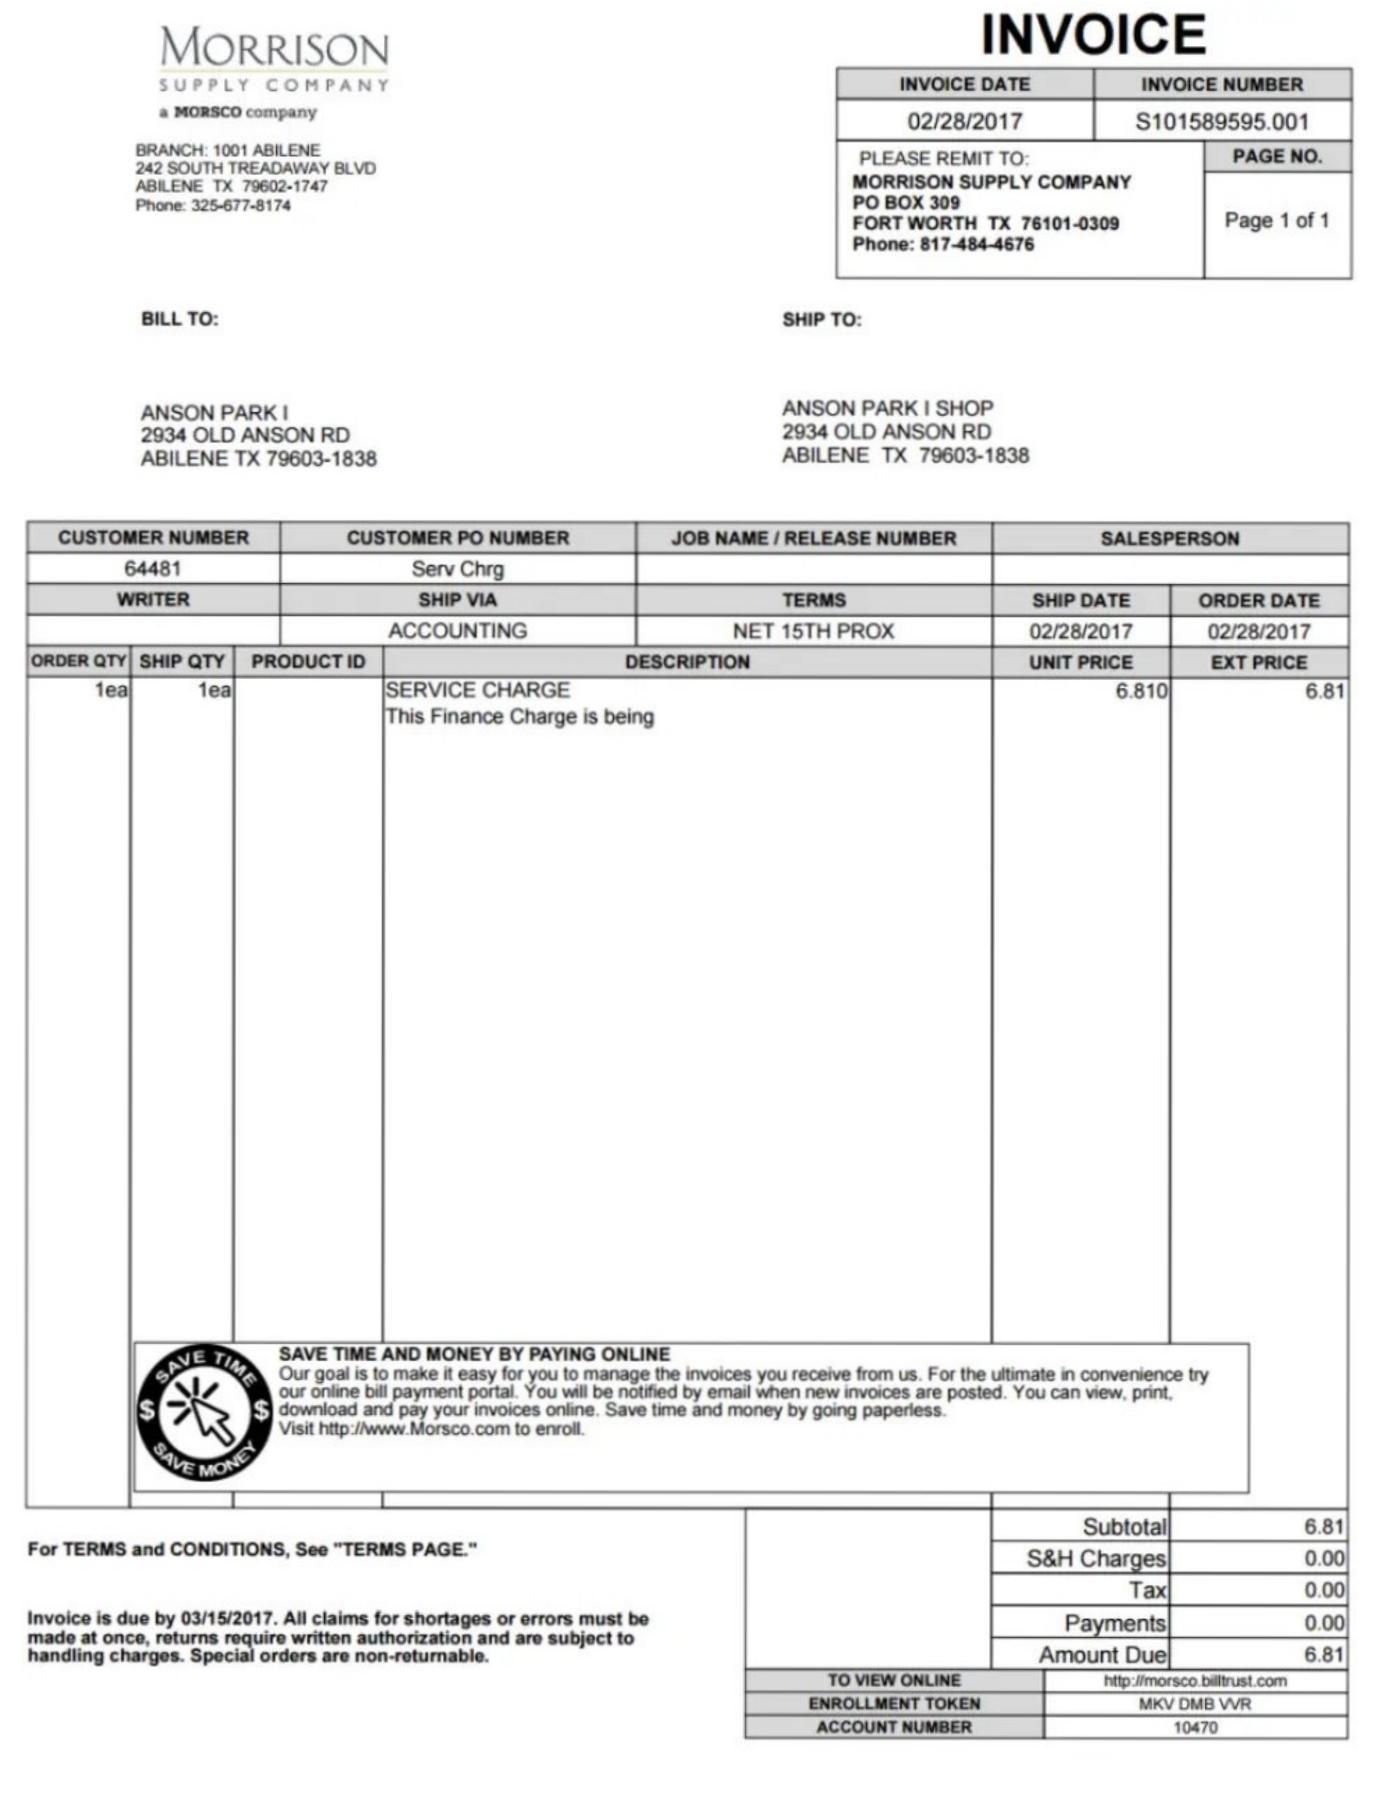

==================== PROCESSING TEST PDF: 'ikea' =========================

Output info:

- Number of pages in the file: 12
- Number of content Documents: 66
- Number of content Documents after merging adjacent text Documents: 40
- Number of content chunks after splitting the Documents by page: 2

Printing the content in markdown format
*** Chunk 1 Content ***


*Page 1 content:*


**Figure 1 Info**

*Figure Content:*
A guide to installing a new METOD Kitchen


*Figure Image:*

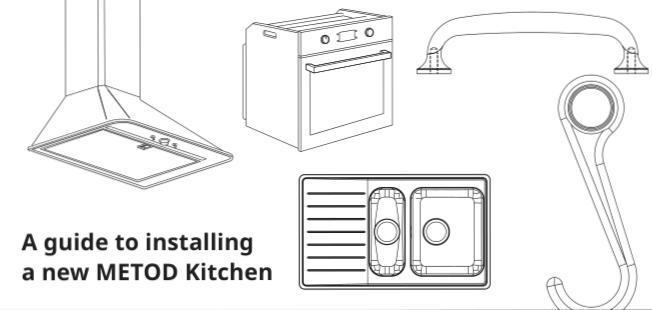


# METOD Kitchen installation guide
This guide provides step-by-step instructions on how to install your new IKEA METOD kitchen.


**Figure 2 Info**



*Figure Image:*

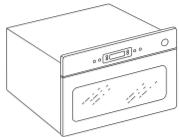



**Figure 3 Info**



*Figure Image:*

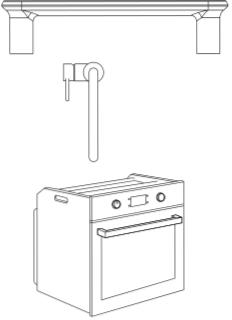



**Figure 4 Info**



*Figure Image:*

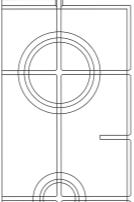



**Figure 5 Info**

*Figure Content:*
IKEA® ®


*Figure Image:*

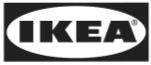



*Page 1 Image:*

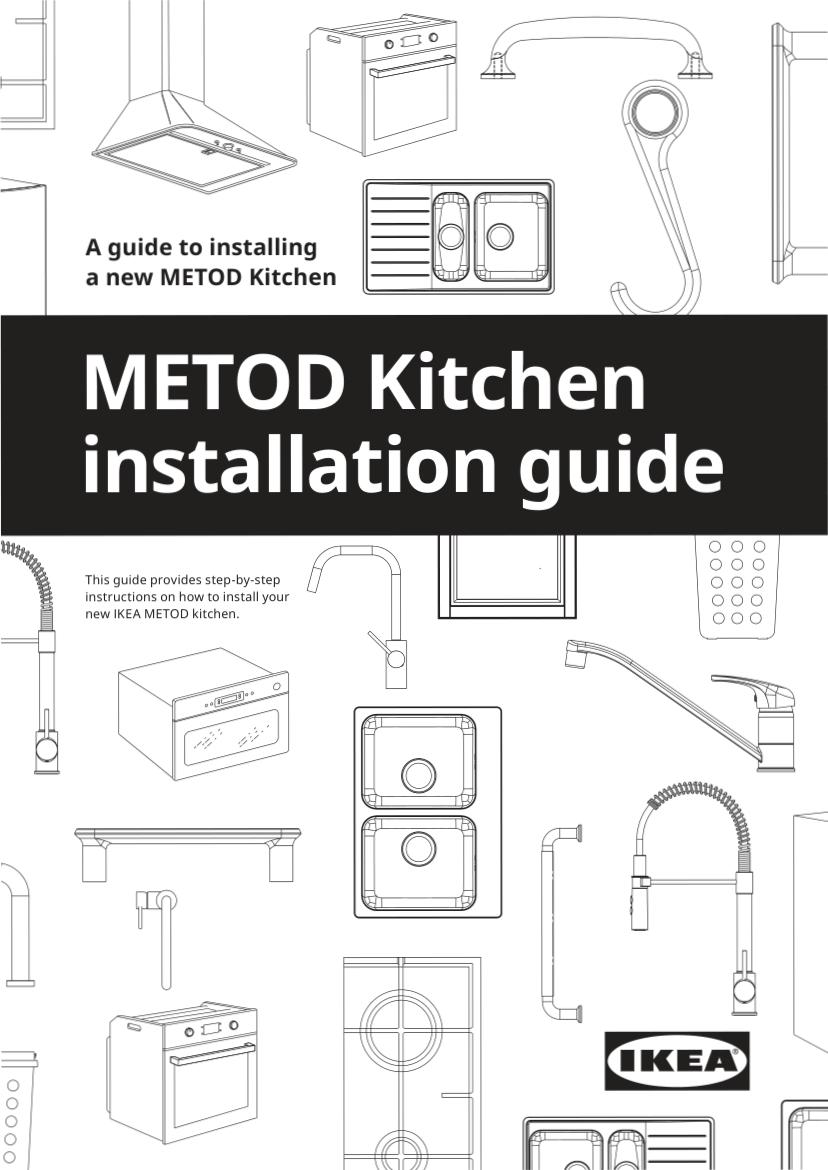




*Page 2 content:*

## Step-by-step guide

### Installing your new IKEA kitchen
This brochure is your guide to preparing and installing your new kitchen. Inside you'll find steps to follow and useful tips and ideas. Use this guide and your IKEA assembly instructions to make sure your kitchen is installed in the right way.

### Before you begin
Go through this brochure before you begin the installation, to see what stages are involved and the tools you'll need. To make sure you have all the components you need, compare the packages and parts against your order list and the freight list. You should only dismantle your old kitchen once you have all your new parts and appliances. Your kitchen parts and benchtop should be stored indoors, in normal room temperature and humidity.
Before you remove your old kitchen make sure that your electricity, gas and water is shut off. Use a qualified trades professional to disconnect and reconnect your gas, water and electricity.
You can do it yourself, but you don't have to Although our kitchens are designed to be as simple as possible for you to assemble and install yourself, it is important to consider all aspects of a kitchen renovation. Some key steps, such as wall cabinet installation or cutting the benchtop, require more skill and expertise than others.
We can offer you services ranging from planning and delivery to complete kitchen installation. For more details see the back page of this guide, the kitchen section of IKEA.com.au or visit your local IKEA store.


**Figure 6 Info**

*Figure Content:*
Once your kitchen arrives, check off your delivery to see that everything is in order.
IKEA Design and Quality


*Figure Image:*

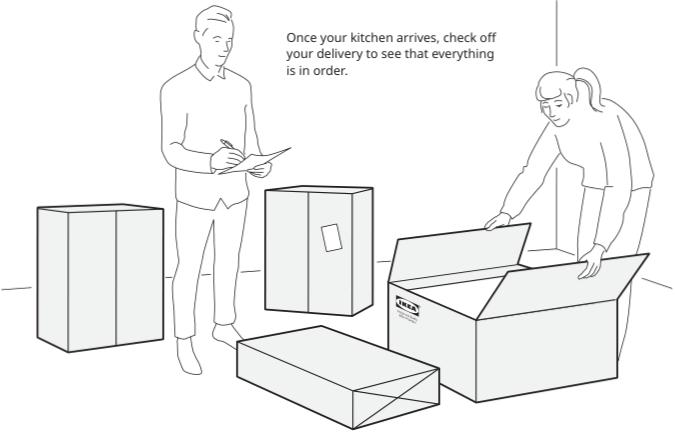



*Page 2 Image:*

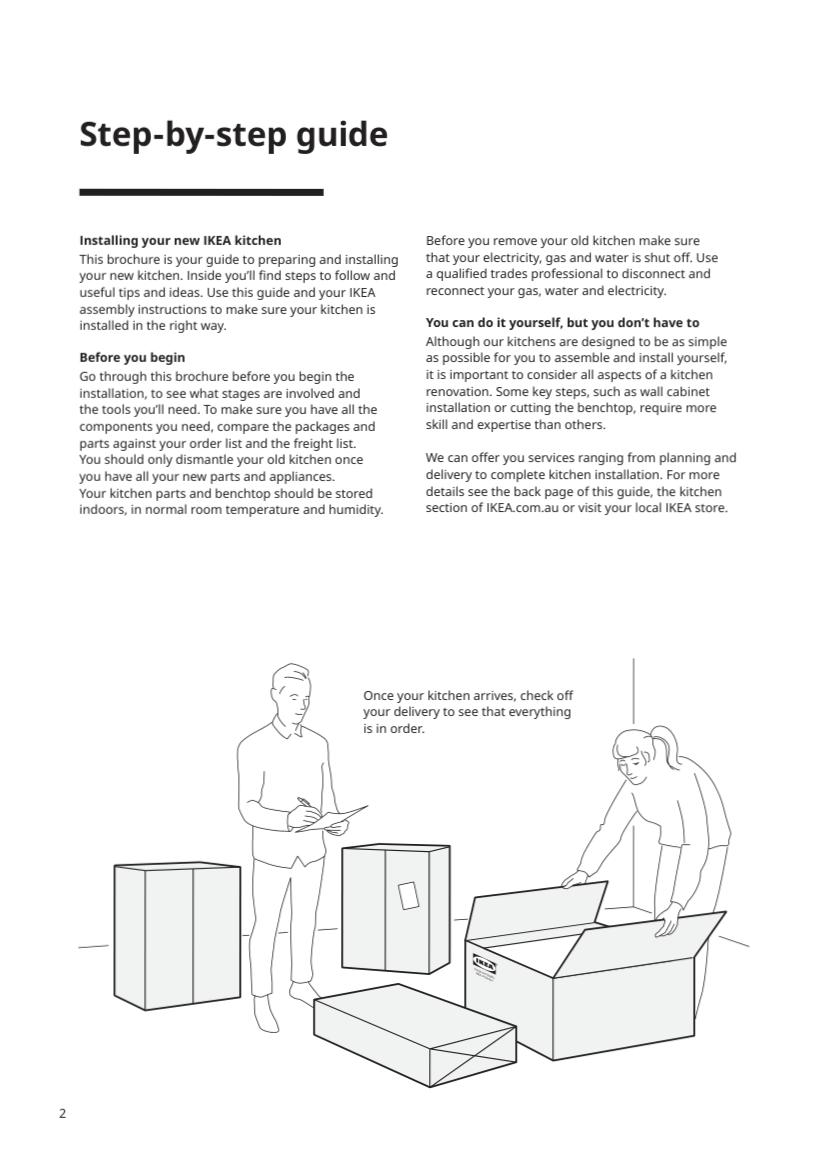




*Page 3 content:*

## Tools and materials
Below is a summary of the basic tools you'll need. In addition you'll find which tools to use for each product in their respective assembly instructions. It's a good idea to wear safety glasses when using power tools.

### Good to know
Plaster, wood or concrete walls? Because there are many different types of walls, fixing hardware is not supplied with your cabinets. Most hardware or home improvement stores stock appropriate fixing hardware and can help you choose the right sort for your walls.


**Figure 7 Info**

*Figure Content:*
Spirit level
Fine-toothed handsaw
Measuring tape
G clamps
Electric drill/ screwdriver
Mitre box and saw
Try square
Flat screwdriver
o)
Jigsaw
Phillips screwdriver
Hammer
Pencil
Hole cutter for drilling the hole for the mixer tap in the sink, Ø35mm
Rubber hammer
Awl
FIXA 2-piece tool set $15 901.768.20
Circular saw


*Figure Image:*

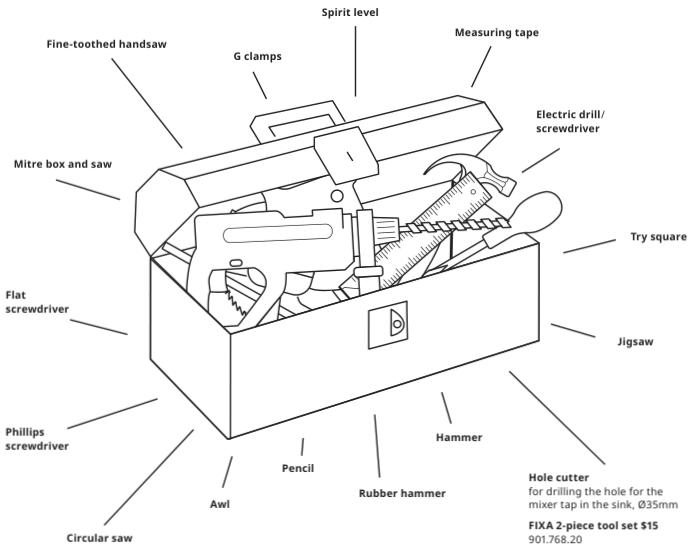



*Page 3 Image:*

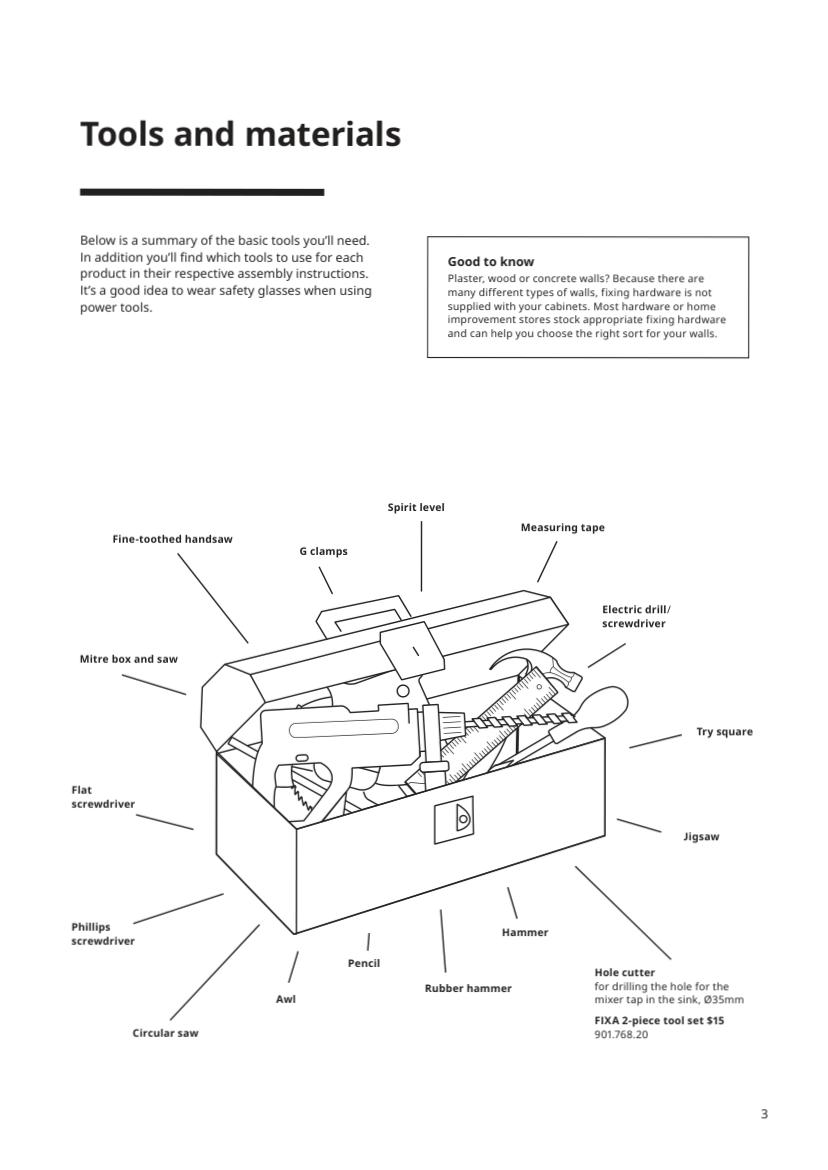




*Page 4 content:*

## Preparing your room
Once you've removed your old kitchen, prepare the room by making sure your walls and floors are even, and the walls are suitable for supporting your new kitchen. Now is also the time to prime and paint walls, put tiles on the walls/floors or change your flooring.

### Marking cabinet positions
Draw a layout of your new kitchen directly on the wall. Check that everything fits with the measurements from your plan, and that electricity, water, gas and ventilation connections are where you want them to be. Also mark where to fasten your new kitchen's suspension rails.


**Figure 8 Info**



*Figure Image:*

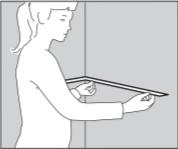

Prepare your space by making sure your corners are even and your walls and floor are straight. Use your try square for the corners and a spirit level for the walls and floor.


**Figure 9 Info**



*Figure Image:*

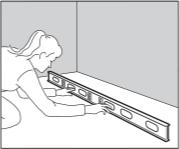

Make sure you note the highest point of the floor and where the corners aren't 90 degrees.


**Figure 10 Info**



*Figure Image:*

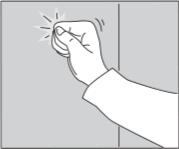

Check your wall is strong enough to hang your suspension rail and cabinets. Depending on your wall material, it's best to install your rail onto a stud or a support beam. Using an electronic stud finder can be helpful.


**Figure 11 Info**

*Figure Content:*
Make sure you leave 82cm between the highest point of your floor and the bottom of your base suspension rail.
Double-check your plumbing is where you want it and fits with your layout plan.
O


*Figure Image:*

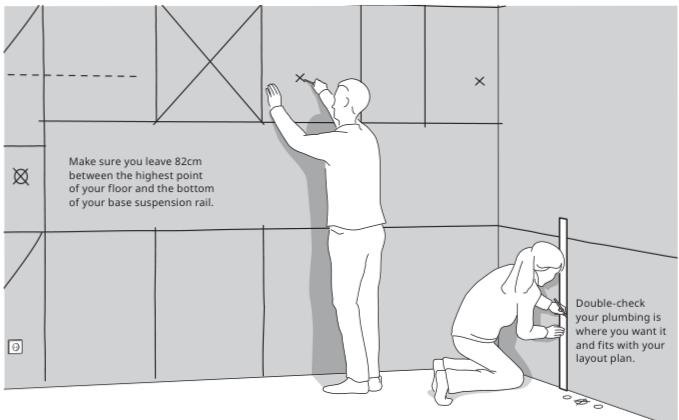



*Page 4 Image:*

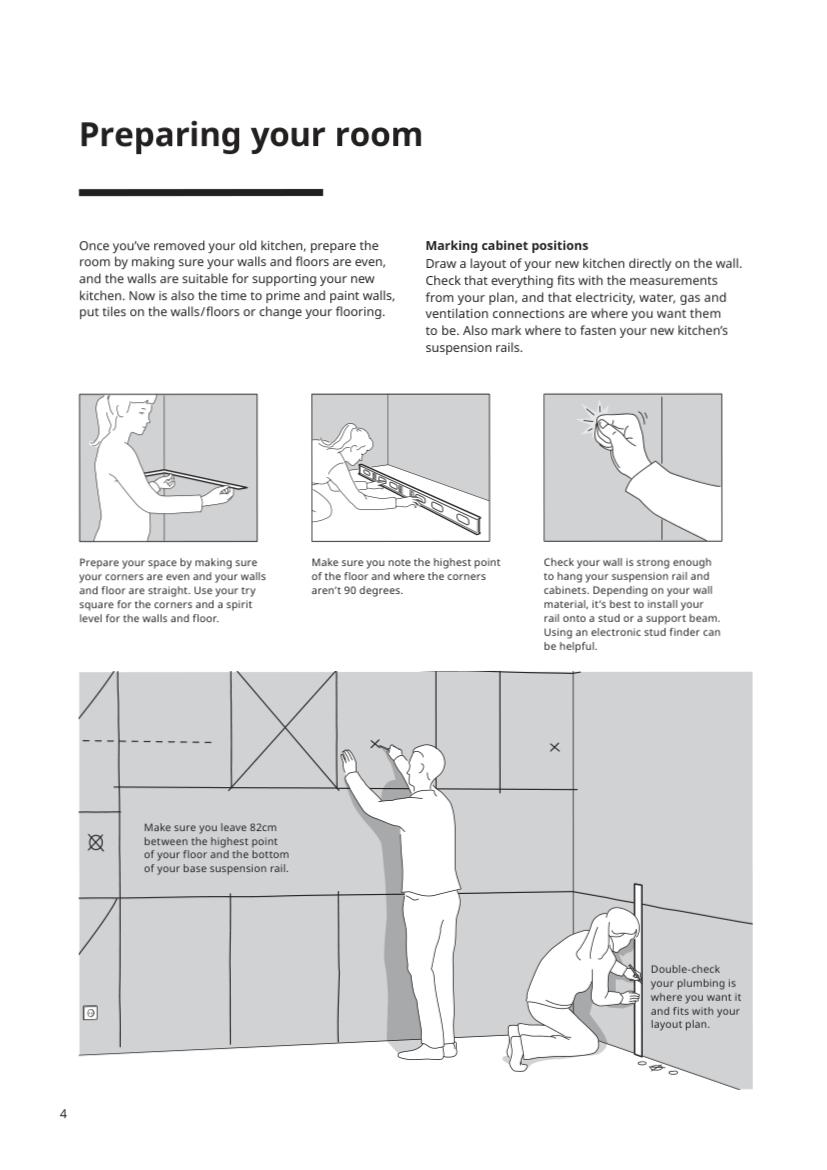




*Page 5 content:*

## Mounting the suspension rails
Your new IKEA cabinets can be hung directly onto a suspension rail making them easier to install and adjust. It's important to make sure your suspension rail is straight and level, and to secure it with the right screw type for your wall.


**Figure 12 Info**



*Figure Image:*

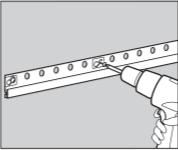

Fasten your rails, base cabinet rails first. Make sure you've found suitable points in the wall where the rails can be fastened, and that the rails are level before drilling.


**Figure 13 Info**



*Figure Image:*

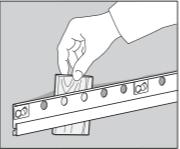

If your wall is uneven use distancers between the rail and the wall to make sure the rail is straight.


**Figure 14 Info**



*Figure Image:*

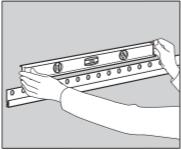

Use a spirit level to check that each rail is level.


**Figure 15 Info**

*Figure Content:*
Kitchen height 208 cm
Wall cabinet height 60cm
202cm
[X]
× [X]
X [X]
× [X]
Q
A
Base cabinet height 80cm
82cm
O
× [X]
Plinth height 8cm
B


*Figure Image:*

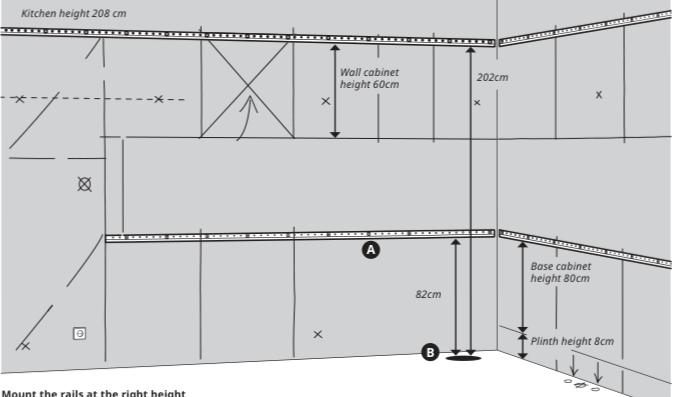



*Page 5 Image:*

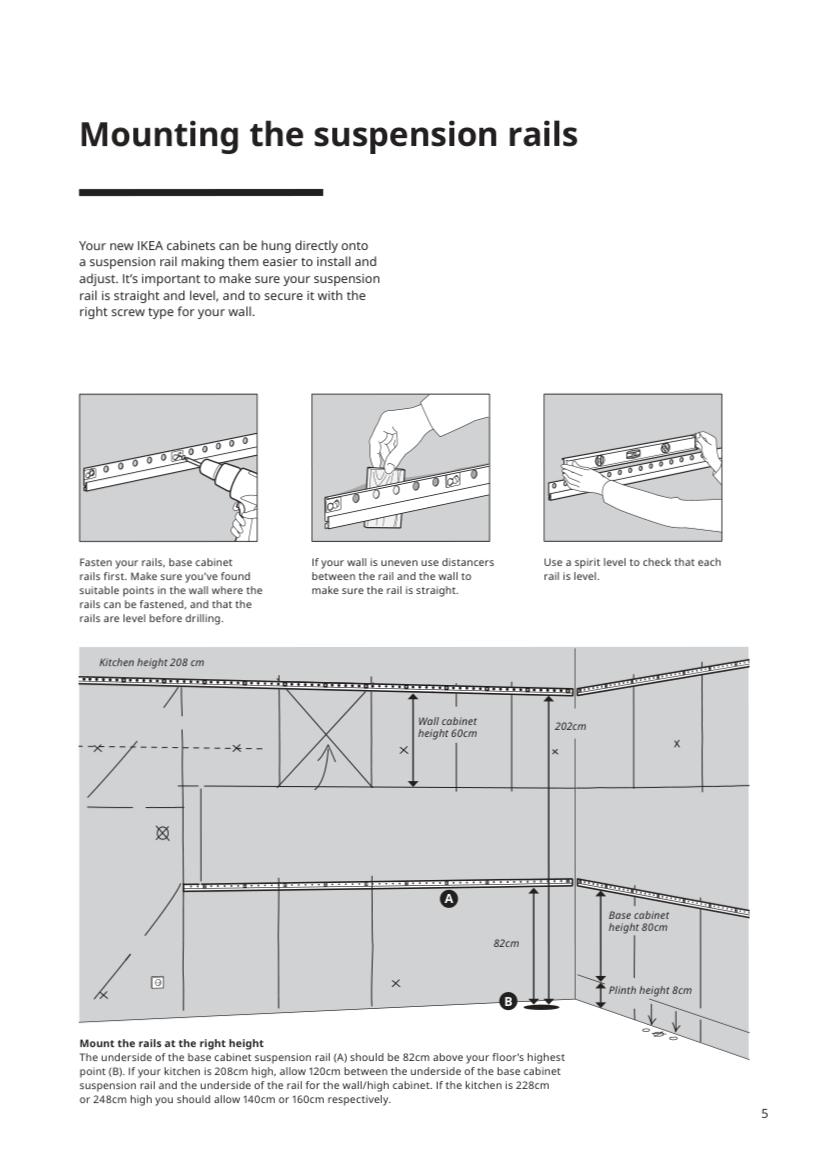

*** Chunk 2 Content ***


*Page 1 content:*


**Figure 1 Info**

*Figure Content:*
A guide to installing a new METOD Kitchen


*Figure Image:*

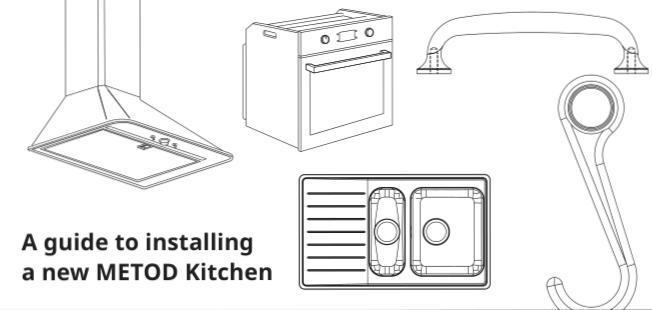


# METOD Kitchen installation guide
This guide provides step-by-step instructions on how to install your new IKEA METOD kitchen.


**Figure 2 Info**



*Figure Image:*

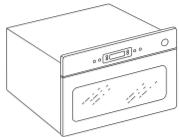



**Figure 3 Info**



*Figure Image:*

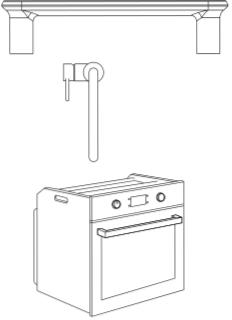



**Figure 4 Info**



*Figure Image:*

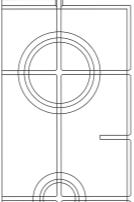



**Figure 5 Info**

*Figure Content:*
IKEA® ®


*Figure Image:*

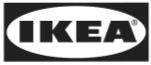



*Page 1 Image:*

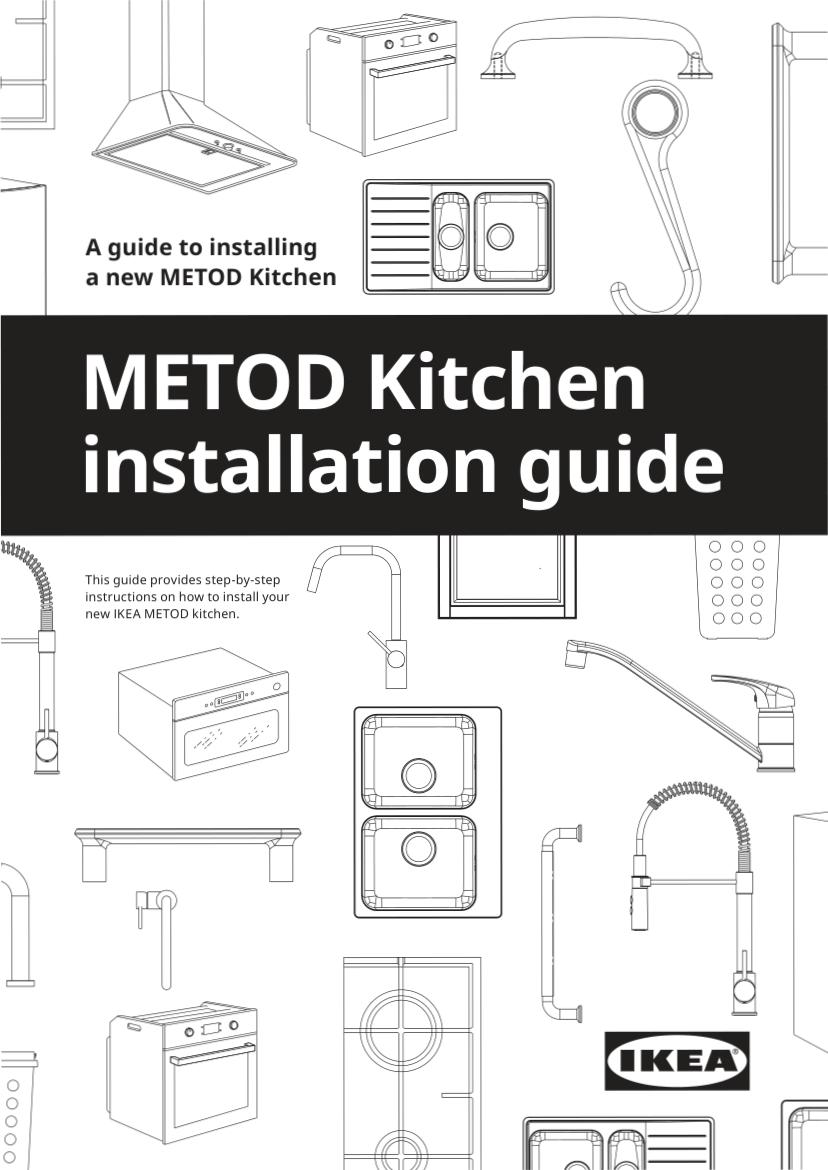




*Page 2 content:*

## Step-by-step guide

### Installing your new IKEA kitchen
This brochure is your guide to preparing and installing your new kitchen. Inside you'll find steps to follow and useful tips and ideas. Use this guide and your IKEA assembly instructions to make sure your kitchen is installed in the right way.

### Before you begin
Go through this brochure before you begin the installation, to see what stages are involved and the tools you'll need. To make sure you have all the components you need, compare the packages and parts against your order list and the freight list. You should only dismantle your old kitchen once you have all your new parts and appliances. Your kitchen parts and benchtop should be stored indoors, in normal room temperature and humidity.
Before you remove your old kitchen make sure that your electricity, gas and water is shut off. Use a qualified trades professional to disconnect and reconnect your gas, water and electricity.
You can do it yourself, but you don't have to Although our kitchens are designed to be as simple as possible for you to assemble and install yourself, it is important to consider all aspects of a kitchen renovation. Some key steps, such as wall cabinet installation or cutting the benchtop, require more skill and expertise than others.
We can offer you services ranging from planning and delivery to complete kitchen installation. For more details see the back page of this guide, the kitchen section of IKEA.com.au or visit your local IKEA store.


**Figure 6 Info**

*Figure Content:*
Once your kitchen arrives, check off your delivery to see that everything is in order.
IKEA Design and Quality


*Figure Image:*

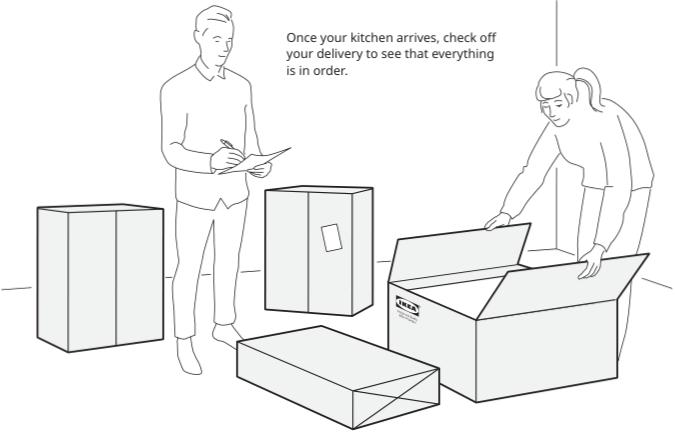



*Page 2 Image:*

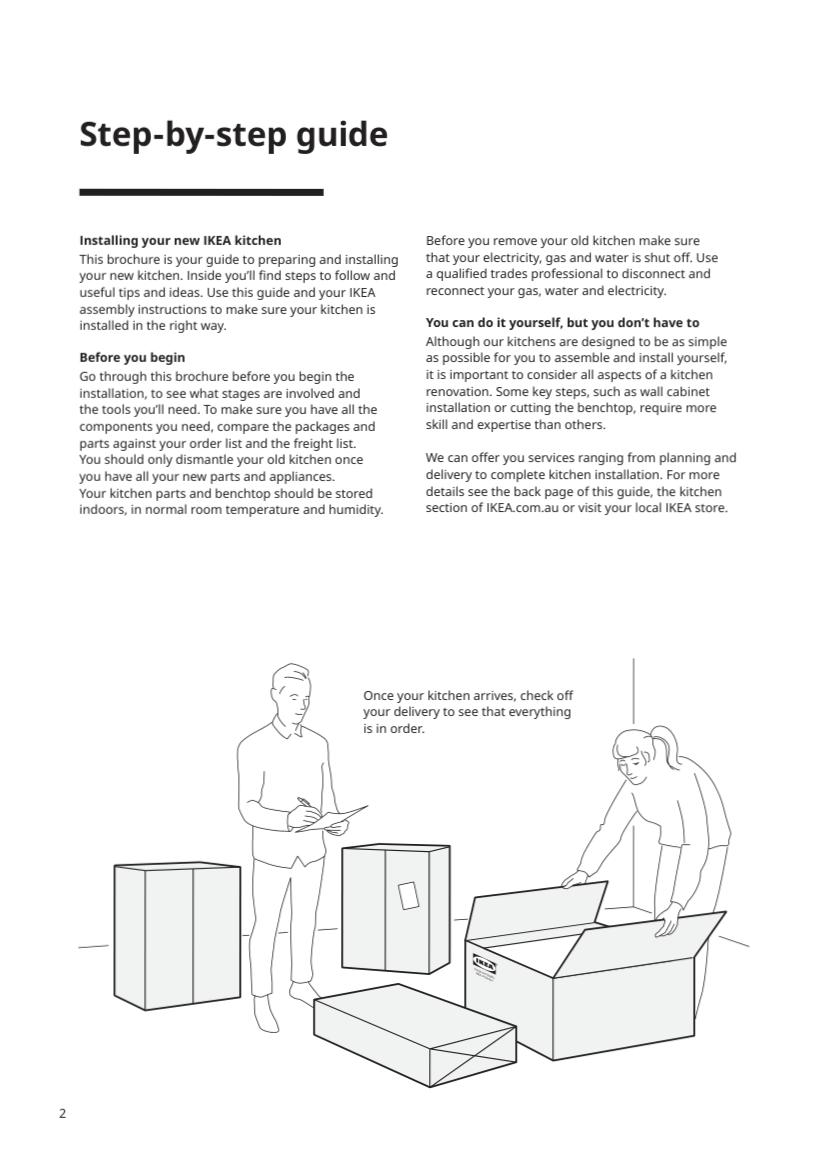




*Page 3 content:*

## Tools and materials
Below is a summary of the basic tools you'll need. In addition you'll find which tools to use for each product in their respective assembly instructions. It's a good idea to wear safety glasses when using power tools.

### Good to know
Plaster, wood or concrete walls? Because there are many different types of walls, fixing hardware is not supplied with your cabinets. Most hardware or home improvement stores stock appropriate fixing hardware and can help you choose the right sort for your walls.


**Figure 7 Info**

*Figure Content:*
Spirit level
Fine-toothed handsaw
Measuring tape
G clamps
Electric drill/ screwdriver
Mitre box and saw
Try square
Flat screwdriver
o)
Jigsaw
Phillips screwdriver
Hammer
Pencil
Hole cutter for drilling the hole for the mixer tap in the sink, Ø35mm
Rubber hammer
Awl
FIXA 2-piece tool set $15 901.768.20
Circular saw


*Figure Image:*

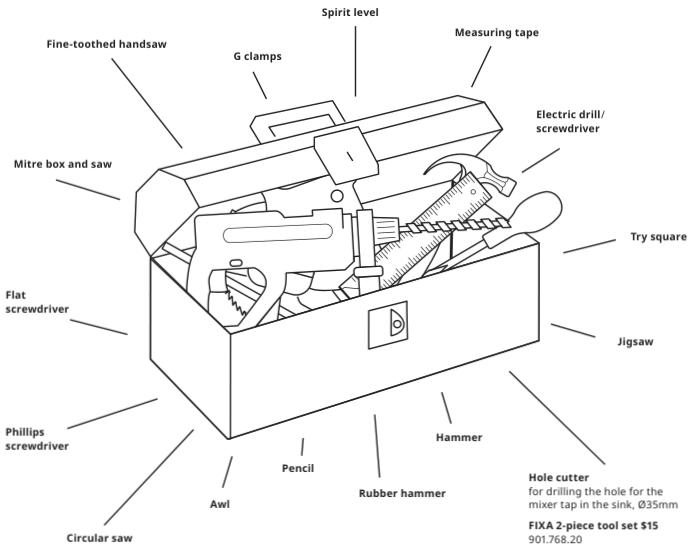



*Page 3 Image:*

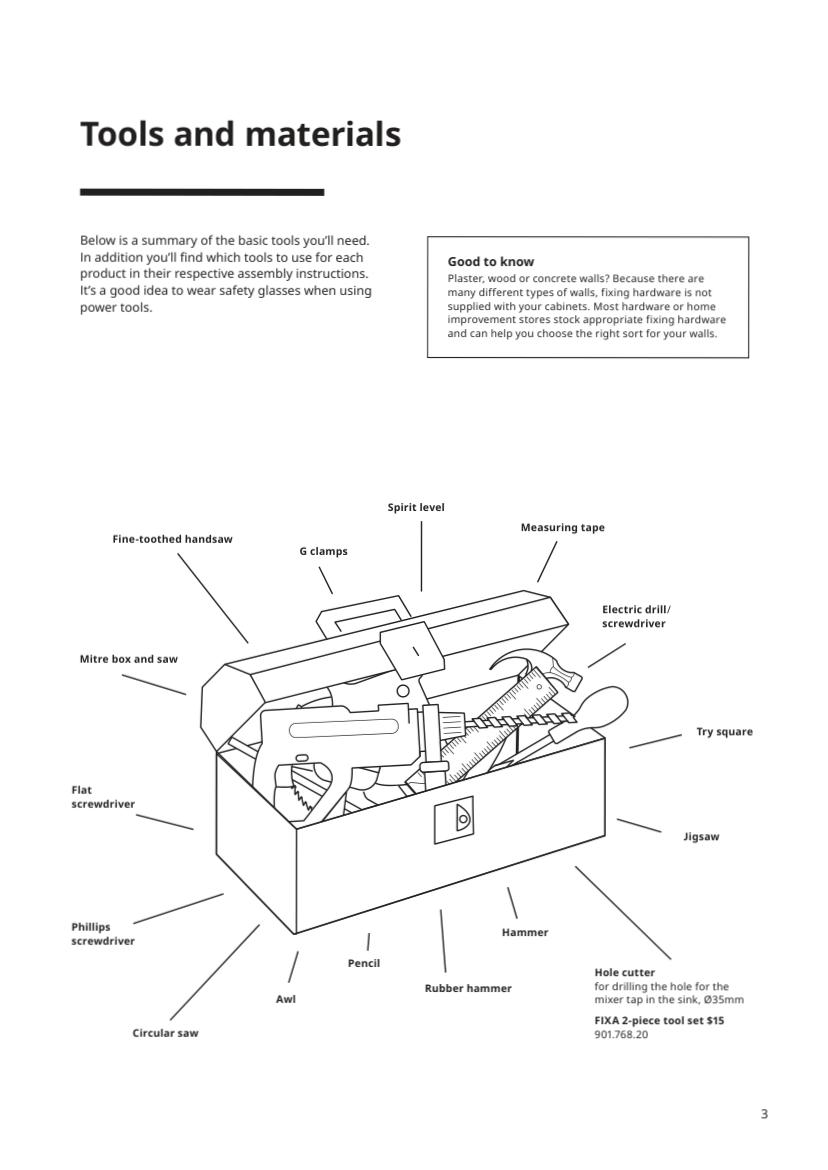




*Page 4 content:*

## Preparing your room
Once you've removed your old kitchen, prepare the room by making sure your walls and floors are even, and the walls are suitable for supporting your new kitchen. Now is also the time to prime and paint walls, put tiles on the walls/floors or change your flooring.

### Marking cabinet positions
Draw a layout of your new kitchen directly on the wall. Check that everything fits with the measurements from your plan, and that electricity, water, gas and ventilation connections are where you want them to be. Also mark where to fasten your new kitchen's suspension rails.


**Figure 8 Info**



*Figure Image:*

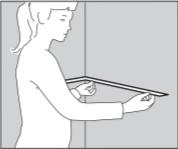

Prepare your space by making sure your corners are even and your walls and floor are straight. Use your try square for the corners and a spirit level for the walls and floor.


**Figure 9 Info**



*Figure Image:*

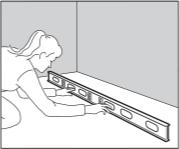

Make sure you note the highest point of the floor and where the corners aren't 90 degrees.


**Figure 10 Info**



*Figure Image:*

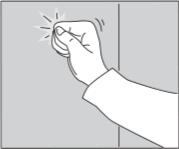

Check your wall is strong enough to hang your suspension rail and cabinets. Depending on your wall material, it's best to install your rail onto a stud or a support beam. Using an electronic stud finder can be helpful.


**Figure 11 Info**

*Figure Content:*
Make sure you leave 82cm between the highest point of your floor and the bottom of your base suspension rail.
Double-check your plumbing is where you want it and fits with your layout plan.
O


*Figure Image:*

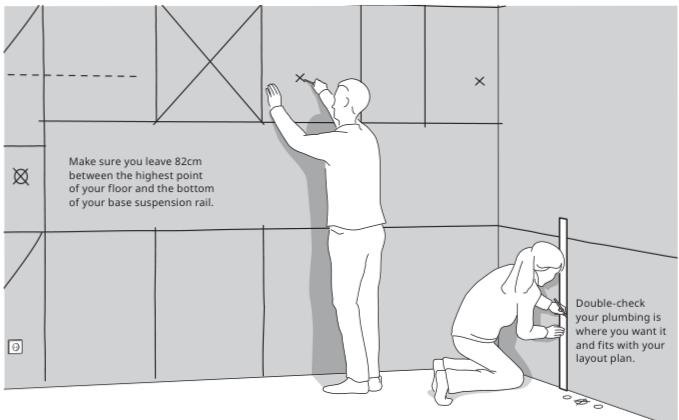



*Page 4 Image:*

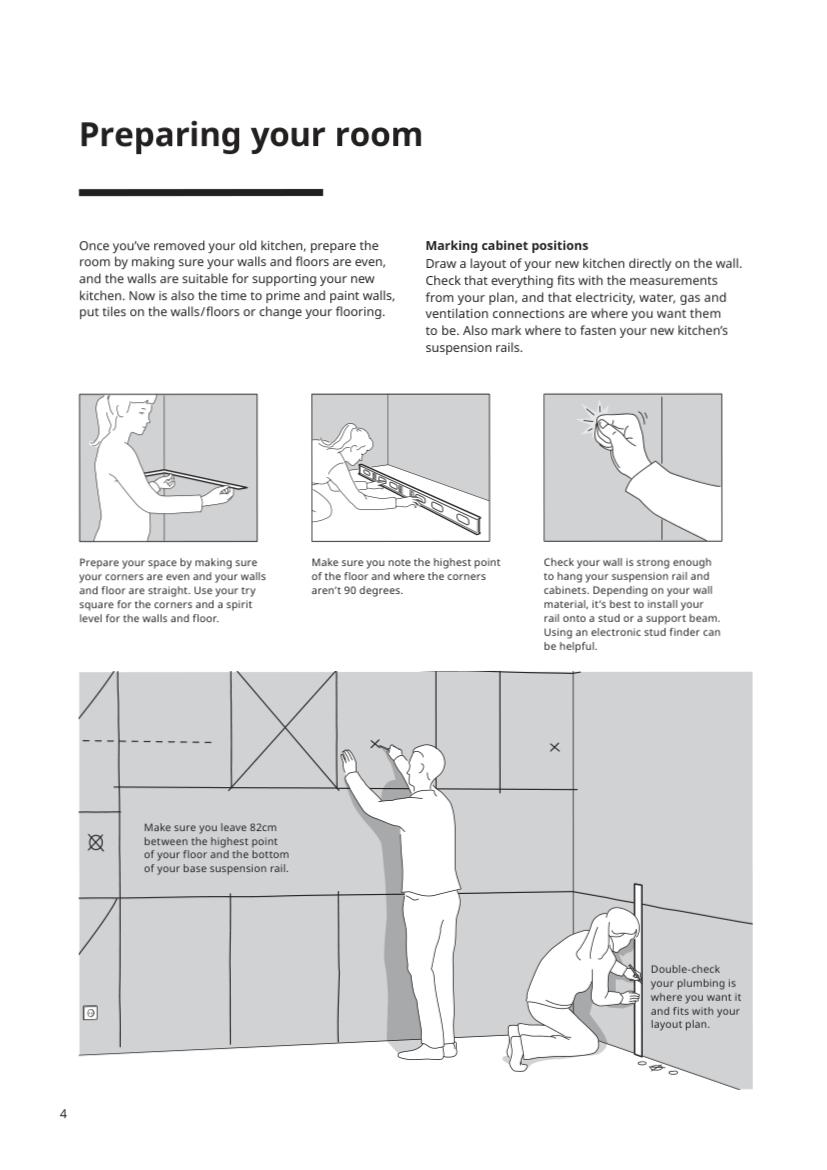




*Page 5 content:*

## Mounting the suspension rails
Your new IKEA cabinets can be hung directly onto a suspension rail making them easier to install and adjust. It's important to make sure your suspension rail is straight and level, and to secure it with the right screw type for your wall.


**Figure 12 Info**



*Figure Image:*

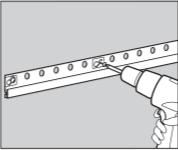

Fasten your rails, base cabinet rails first. Make sure you've found suitable points in the wall where the rails can be fastened, and that the rails are level before drilling.


**Figure 13 Info**



*Figure Image:*

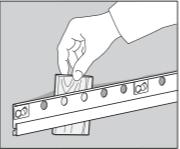

If your wall is uneven use distancers between the rail and the wall to make sure the rail is straight.


**Figure 14 Info**



*Figure Image:*

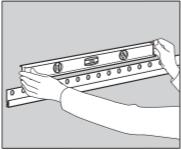

Use a spirit level to check that each rail is level.


**Figure 15 Info**

*Figure Content:*
Kitchen height 208 cm
Wall cabinet height 60cm
202cm
[X]
× [X]
X [X]
× [X]
Q
A
Base cabinet height 80cm
82cm
O
× [X]
Plinth height 8cm
B


*Figure Image:*

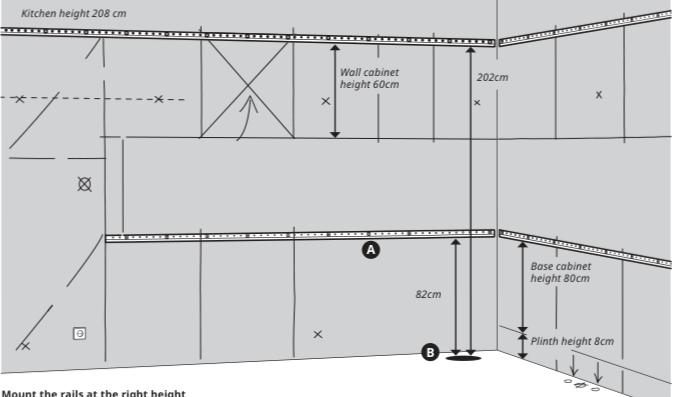



*Page 5 Image:*

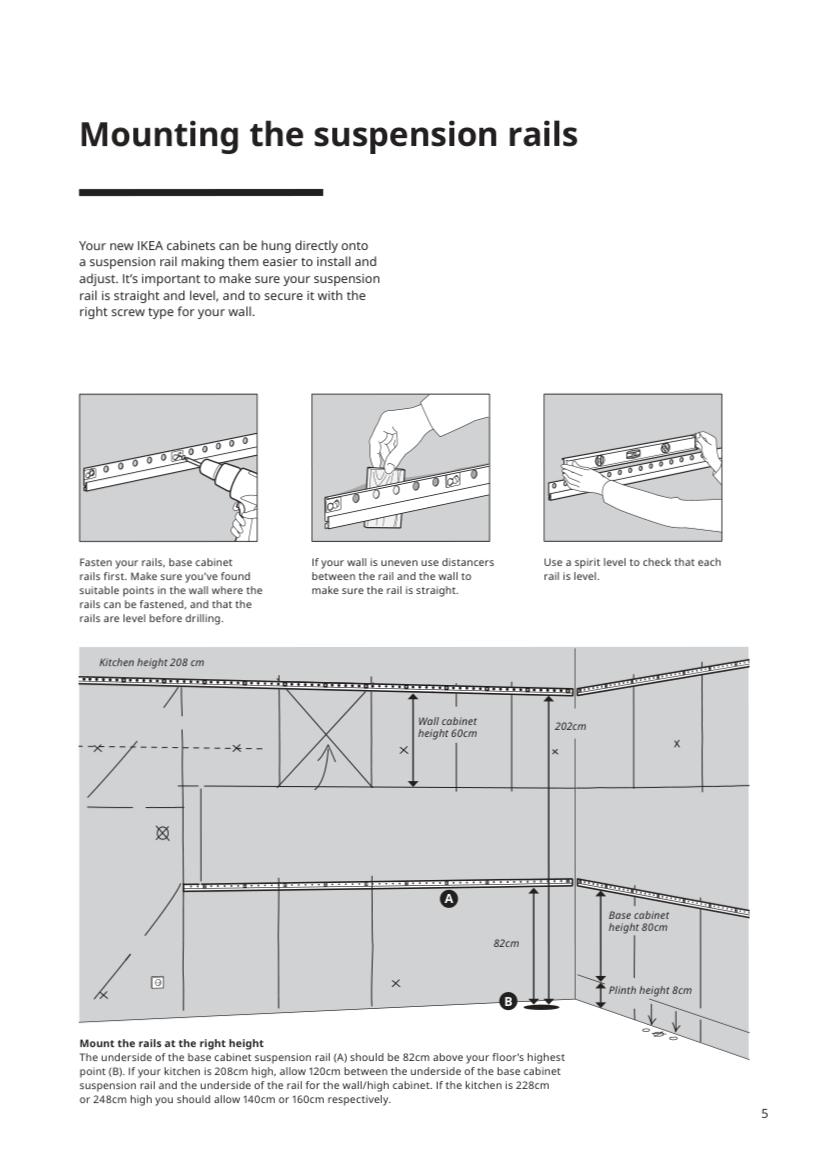

In [8]:
# Set the list of sample PDFs to process
TEST_PDF_NAMES = ["rotated_proof_of_delivery_pdf", "ikea"]

# Set the max number of elements to process before stopping (this prevents the notebook from getting too long)
BREAK_AFTER_ELEMENT_IDX = 1000

for test_pdf_name in TEST_PDF_NAMES:
    print(f"==================== PROCESSING TEST PDF: '{test_pdf_name}' =========================\n")
    # Load the PDF with PyMuPDF and convert the pages to images. We need to do this to get the images for the pages and figures.
    pdf_url = doc_intelligence_test_files[test_pdf_name].url_source
    pdf = load_pymupdf_pdf(pdf_path=None, pdf_url=pdf_url)
    doc_page_imgs = extract_pdf_page_images(pdf, img_dpi=100, starting_idx=1)

    # Get Doc Intelligence result
    di_result = get_analyze_document_result(
        sample_pdf_file_info=doc_intelligence_test_files[test_pdf_name], 
        di_client=di_client,
        model_id=di_model_id, 
        features=di_features,
    )

    # Process the API response with the processor
    processed_content_docs = doc_intel_result_processor.process_analyze_result(
        di_result, 
        doc_page_imgs=doc_page_imgs, 
        on_error="raise", 
        break_after_element_idx=BREAK_AFTER_ELEMENT_IDX
    )

    # Split the results into chunks
    page_chunked_content_docs = chunk_splitter.split_document_list(processed_content_docs)

    # By default, each element outputs a separate data class. Converting these to LLM messages would
    # result in hundreds or thousands of messages for each PDF. We can merge adjacent text elements together
    # to reduce their quantity prior to converting them into LLM messages.
    merged_subchunk_content_docs = doc_intel_result_processor.merge_adjacent_text_content_docs(page_chunked_content_docs)

    print("Output info:")
    print("\n- Number of pages in the file:", len(doc_page_imgs))
    print("- Number of content Documents:", len(processed_content_docs))
    print("- Number of content Documents after merging adjacent text Documents:", sum([len(l) for l in merged_subchunk_content_docs]))
    print("- Number of content chunks after splitting the Documents by page:", len(page_chunked_content_docs))

    # Convert content to OpenAI messages
    all_content_openai_message = convert_processed_di_docs_to_openai_message(processed_content_docs, role="user")
    first_chunk_openai_message = convert_processed_di_docs_to_openai_message(merged_subchunk_content_docs[0], role="user")
    
    # print("\nAll content OpenAI messages:")
    # all_content_openai_message
    # print("First chunk OpenAI messages:")
    # first_chunk_openai_message

    # Print content in the notebook
    print("\nPrinting the content in markdown format")
    for chunk_num, chunk in enumerate(merged_subchunk_content_docs, start=1):
        print(f"*** Chunk {chunk_num} Content ***")
        md(convert_processed_di_docs_to_markdown(processed_content_docs))

# Send the document contents to Azure OpenAI
With the document now processed, we can easily convert the output into messages that are ready for processing with Azure OpenAI.

In [9]:
from openai import AzureOpenAI

AOAI_LLM_DEPLOYMENT = os.getenv("AOAI_LLM_DEPLOYMENT")
AOAI_ENDPOINT = os.getenv("AOAI_ENDPOINT")
AOAI_API_KEY = os.getenv("AOAI_API_KEY")

aoai_client = AzureOpenAI(
    azure_endpoint=AOAI_ENDPOINT,
    azure_deployment=AOAI_LLM_DEPLOYMENT,
    api_key=AOAI_API_KEY,
    api_version="2024-06-01",
    timeout=30,
    max_retries=0,
)

In [10]:
messages = [
    {
        "role": "system",
        "content": "Please summarize the content of the following file into 100 words or less.",
    },
    first_chunk_openai_message,
]
response = aoai_client.chat.completions.create(
    messages=messages,
    model=AOAI_LLM_DEPLOYMENT
)
print(response.choices[0].message.content)

The METOD Kitchen Installation Guide by IKEA offers step-by-step instructions for preparing and installing a new kitchen. It advises checking all parts upon delivery and provides a detailed list of necessary tools and materials, such as a spirit level, measuring tape, screwdriver, and electric drill. The guide emphasizes safety, suggesting the use of safety glasses when using power tools and recommending hiring a qualified professional for certain tasks. It encourages planning and proper storage of kitchen parts before beginning installation.
